In [1]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567858 sha256=917b1f96c8d13550f49dee21a35448aad1dc5a23943455ebb0e84045ba9317d4
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
COLUMN_NAMES = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',    # 0-2 (Chest Acc)
    'ecg_1', 'ecg_2',                               # 3-4 (ECG)
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',    # 5-7 (Ankle Acc)
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z', # 8-10 (Ankle Gyro)
    'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',    # 11-13 (Ankle Mag)
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',          # 14-16 (Arm Acc)
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',       # 17-19 (Arm Gyro)
    'mag_arm_x', 'mag_arm_y', 'mag_arm_z',          # 20-22 (Arm Mag)
    'activity_id'                                   # 23 (Label)
]

target_activities = {
    4: 'Walking',                   # 비교군 1 (동작의 구분감)
    6: 'Waist bends forward',       # 후보 1
    7: 'Frontal elevation of arms', # 후보 2
    8: 'Knees bending',             # 후보 3
    9: 'Cycling',                   # 비교군 2 (동작 속도의 적합성)
    12: 'Jump front & back'         # 비교군 3 (단축 동작)
}

def load_mhealth_dataset(data_dir='./'):
    full_dataset = {}

    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"Error: No files found in directory '{data_dir}'. Check the path and file names.")
        return {}

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_id = file_name.split('.')[0].replace('_', '')

        df = pd.read_csv(file_path, sep="\t", header=None)
        if df.shape[1] == len(COLUMN_NAMES):
            df.columns = COLUMN_NAMES
        else:
            print(f"Warning: {subj_id} has {df.shape[1]} columns, expected {len(COLUMN_NAMES)}.")

        subj_data = {}

        for label_code, activity_name in target_activities.items():
            activity_df = df[df['activity_id'] == label_code].copy()

            if not activity_df.empty:
                subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

        full_dataset[subj_id] = subj_data

    print(f"\nSuccessfully loaded data for {len(full_dataset)} subjects.")
    return full_dataset

data_directory = '/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET'
mhealth_data = load_mhealth_dataset(data_directory)


Successfully loaded data for 10 subjects.


# 제안 방법
Motion Difficulty Index: $MDI_{total} = w_1 \cdot S_{drift} + w_2 \cdot S_{rotation} + w_3 \cdot S_{ambiguity}$

STARTING MDI INTEGRATED ANALYSIS...

>> Target Activity: Waist bends forward
   [1/4] Calculating Ambiguity...
   [2/4] Calculating Drift & Rotation...
   [3/4] Ranking and Sorting...
   [Done] HQ: 5 subjects | LQ: 5 subjects


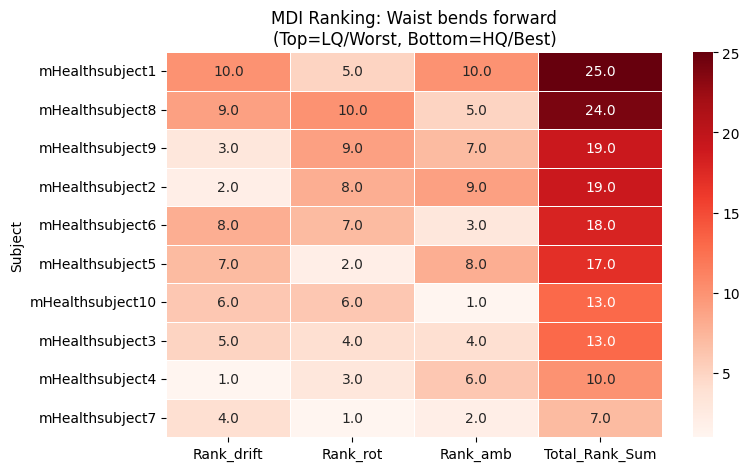


>> Target Activity: Frontal elevation of arms
   [1/4] Calculating Ambiguity...
   [2/4] Calculating Drift & Rotation...
   [3/4] Ranking and Sorting...
   [Done] HQ: 5 subjects | LQ: 5 subjects


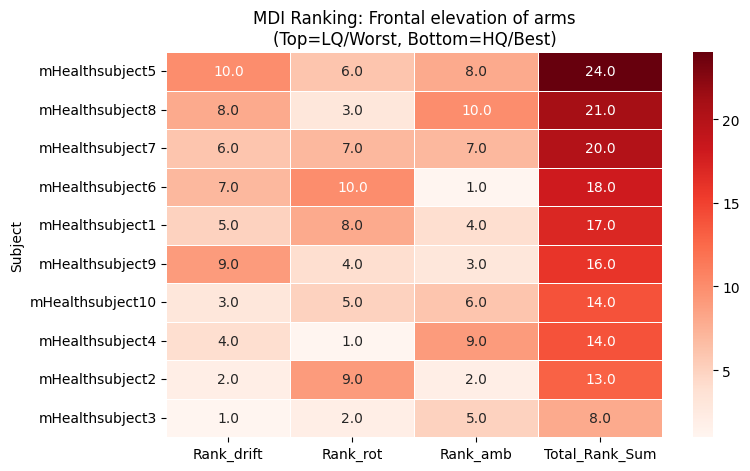


>> Target Activity: Knees bending
   [1/4] Calculating Ambiguity...
   [2/4] Calculating Drift & Rotation...
   [3/4] Ranking and Sorting...
   [Done] HQ: 5 subjects | LQ: 5 subjects


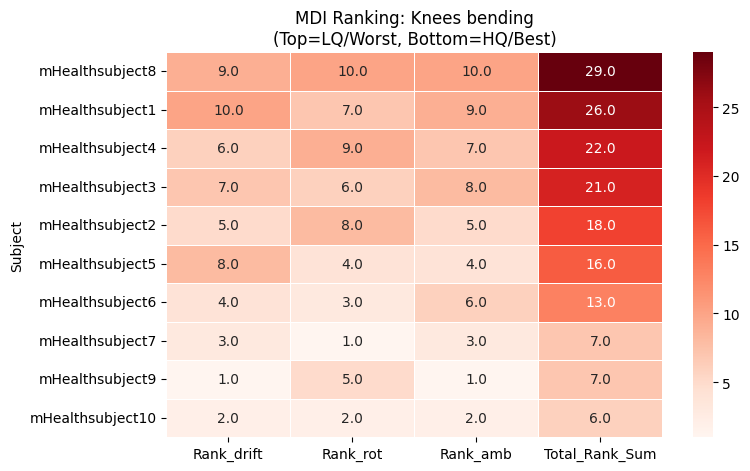


>> Target Activity: Jump front & back
   [1/4] Calculating Ambiguity...
   [2/4] Calculating Drift & Rotation...
   [3/4] Ranking and Sorting...
   [Done] HQ: 5 subjects | LQ: 5 subjects


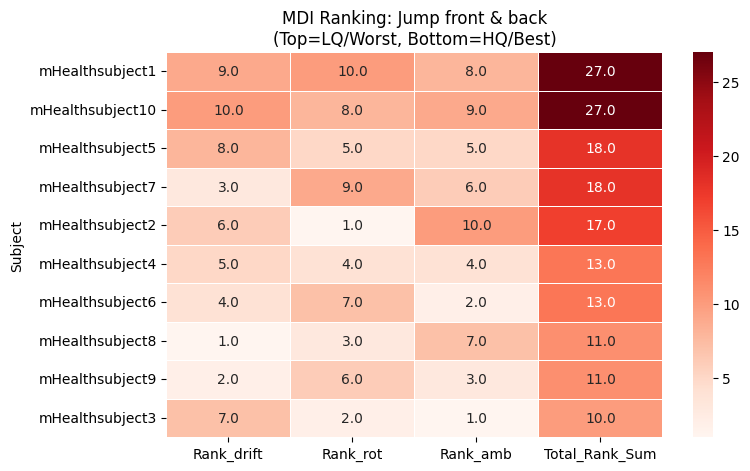


FINAL HQ/LQ GROUPS (MDI BASED)
{
    "Waist bends forward": {
        "HQ": [
            "mHealthsubject5",
            "mHealthsubject10",
            "mHealthsubject3",
            "mHealthsubject4",
            "mHealthsubject7"
        ],
        "LQ": [
            "mHealthsubject1",
            "mHealthsubject8",
            "mHealthsubject9",
            "mHealthsubject2",
            "mHealthsubject6"
        ]
    },
    "Frontal elevation of arms": {
        "HQ": [
            "mHealthsubject9",
            "mHealthsubject10",
            "mHealthsubject4",
            "mHealthsubject2",
            "mHealthsubject3"
        ],
        "LQ": [
            "mHealthsubject5",
            "mHealthsubject8",
            "mHealthsubject7",
            "mHealthsubject6",
            "mHealthsubject1"
        ]
    },
    "Knees bending": {
        "HQ": [
            "mHealthsubject5",
            "mHealthsubject6",
            "mHealthsubject7",
            "mHealthsubject9",
 

In [5]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import entropy

# =========================================================
# 1. 설정: 타겟 동작 및 센서 매핑
# =========================================================
ACT_SENSOR_MAP = {
    'Waist bends forward': ['acc_chest_x', 'acc_chest_y', 'acc_chest_z'],
    'Frontal elevation of arms': ['acc_arm_x', 'acc_arm_y', 'acc_arm_z'],
    'Knees bending': ['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z'],
    'Jump front & back': ['acc_chest_x', 'acc_chest_y', 'acc_chest_z']
}

# Ambiguity 계산용 배경 동작 (반드시 데이터에 포함되어 있어야 함)
BACKGROUND_ACTS = ['Walking', 'Standing', 'Climbing stairs up']

# =========================================================
# 2. 개별 지표 계산 함수들
# =========================================================

# [지표 1] S_drift (시간적 불안정성)
def calculate_s_drift(acc_data):
    if len(acc_data) < 50: return 0.0
    mag = np.linalg.norm(acc_data, axis=1)
    split_idx = int(len(mag) * 0.3)

    first_part = mag[:split_idx].reshape(-1, 1)
    last_part = mag[-split_idx:].reshape(-1, 1)

    distance, path = fastdtw(first_part, last_part, dist=euclidean)
    return distance / len(path)

# [지표 2] S_rotation (센서 부착 비틀림)
def calculate_s_rotation(acc_data):
    if len(acc_data) < 10: return 0.0
    pca = PCA(n_components=1)
    pca.fit(acc_data)
    pc1 = pca.components_[0]

    axes = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    similarities = np.abs(np.dot(axes, pc1))
    return 1 - np.max(similarities)

# [지표 3] 특징 추출 (Ambiguity용 통계값)
def extract_stats_features(df, sensor_cols):
    try:
        acc_data = df[sensor_cols].values
    except KeyError:
        return np.array([])

    window_size = 50
    features = []
    for i in range(0, len(acc_data) - window_size, window_size):
        segment = acc_data[i:i+window_size]
        # Mean, Std, Max, Min
        feat = np.concatenate([
            np.mean(segment, axis=0), np.std(segment, axis=0),
            np.max(segment, axis=0), np.min(segment, axis=0)
        ])
        features.append(feat)
    return np.array(features)

# =========================================================
# 3. 메인 통합 루프 (MDI Ranking)
# =========================================================
final_mdi_results = {}

print("STARTING MDI INTEGRATED ANALYSIS...")
print("=" * 60)

for target_act, sensor_cols in ACT_SENSOR_MAP.items():
    print(f"\n>> Target Activity: {target_act}")

    # -----------------------------------------------------
    # Phase A. S_ambiguity (전체 데이터셋 필요)
    # -----------------------------------------------------
    print("   [1/4] Calculating Ambiguity...")

    # 데이터셋 구축
    X_total, y_total, s_total = [], [], []
    current_act_list = [target_act] + BACKGROUND_ACTS
    act_to_id = {name: i for i, name in enumerate(current_act_list)}

    for subj_id, acts in mhealth_data.items():
        for act_name in current_act_list:
            if act_name not in acts: continue
            feats = extract_stats_features(acts[act_name], sensor_cols)
            if len(feats) == 0: continue
            X_total.append(feats)
            y_total.append(np.full(len(feats), act_to_id[act_name]))
            s_total.append(np.full(len(feats), subj_id))

    if not X_total:
        print("   [Error] No data for Ambiguity calculation.")
        continue

    X_total = np.concatenate(X_total)
    y_total = np.concatenate(y_total)
    s_total = np.concatenate(s_total)

    # LOOCV로 Ambiguity 계산
    amb_scores = {}
    unique_subjs = np.unique(s_total)

    for target_subj in unique_subjs:
        train_mask = (s_total != target_subj)
        X_train, y_train = X_total[train_mask], y_total[train_mask]

        test_mask = (s_total == target_subj) & (y_total == act_to_id[target_act])
        X_test = X_total[test_mask]

        if len(X_test) == 0:
            amb_scores[target_subj] = 0.0 # 데이터 없으면 0 처리
            continue

        clf = RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_leaf=10, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)
        probs = np.clip(probs, 1e-10, 1.0 - 1e-10)
        amb_scores[target_subj] = np.mean(entropy(probs.T))

    # -----------------------------------------------------
    # Phase B. Drift & Rotation (개별 계산)
    # -----------------------------------------------------
    print("   [2/4] Calculating Drift & Rotation...")

    subject_metrics = []

    for subj_id, acts in mhealth_data.items():
        if target_act not in acts: continue

        df = acts[target_act]
        raw_data = df[sensor_cols].values

        # S_drift
        s_drift = calculate_s_drift(raw_data)

        # S_rotation
        s_rot = calculate_s_rotation(raw_data)

        # S_ambiguity (위에서 구한 것 가져오기)
        s_amb = amb_scores.get(subj_id, 0.0) # 없으면 0.0
        # (주의: 만약 데이터 부족으로 amb 계산 못했으면 0점이 되어버리니, 체크 필요)
        # 여기서는 편의상 0으로 두되, 실제 분석시엔 제외하는게 맞음.

        subject_metrics.append({
            'Subject': subj_id,
            'S_drift': s_drift,
            'S_rotation': s_rot,
            'S_ambiguity': s_amb
        })

    # -----------------------------------------------------
    # Phase C. Ranking & Integration
    # -----------------------------------------------------
    print("   [3/4] Ranking and Sorting...")

    df_res = pd.DataFrame(subject_metrics)
    if df_res.empty: continue

    df_res = df_res.set_index('Subject')

    # 랭킹 산정 (점수가 높을수록 나쁨 = 높은 등수 = 큰 숫자)
    # 예: 점수 0.9 (나쁨) -> Rank 10
    # 예: 점수 0.1 (좋음) -> Rank 1
    df_res['Rank_drift'] = df_res['S_drift'].rank(ascending=True)
    df_res['Rank_rot'] = df_res['S_rotation'].rank(ascending=True)
    df_res['Rank_amb'] = df_res['S_ambiguity'].rank(ascending=True)

    # 통합 점수 (랭크의 합)
    df_res['Total_Rank_Sum'] = df_res['Rank_drift'] + df_res['Rank_rot'] + df_res['Rank_amb']

    # 정렬: Total Rank Sum이 높은 순서대로 (나쁜 놈이 위로, 좋은 놈이 아래로)
    # 우리가 원하는 LQ = 위쪽(Top), HQ = 아래쪽(Bottom)
    df_sorted = df_res.sort_values('Total_Rank_Sum', ascending=False)

    # -----------------------------------------------------
    # Phase D. HQ/LQ Grouping
    # -----------------------------------------------------
    n_total = len(df_sorted)
    mid = n_total // 2

    # 상위 50% (랭크 합이 높은 = 나쁜) -> LQ
    lq_group = df_sorted.index[:mid].tolist()
    # 하위 50% (랭크 합이 낮은 = 좋은) -> HQ
    hq_group = df_sorted.index[mid:].tolist()

    final_mdi_results[target_act] = {
        'HQ': hq_group,
        'LQ': lq_group
    }

    print(f"   [Done] HQ: {len(hq_group)} subjects | LQ: {len(lq_group)} subjects")

    # (선택) 시각화: 랭킹 히트맵
    plt.figure(figsize=(8, 5))
    sns.heatmap(df_sorted[['Rank_drift', 'Rank_rot', 'Rank_amb', 'Total_Rank_Sum']],
                annot=True, fmt='.1f', cmap='Reds', linewidths=.5)
    plt.title(f'MDI Ranking: {target_act}\n(Top=LQ/Worst, Bottom=HQ/Best)')
    plt.show()

# =========================================================
# 4. 최종 JSON 출력
# =========================================================
print("\n" + "="*60)
print("FINAL HQ/LQ GROUPS (MDI BASED)")
print("="*60)
print(json.dumps(final_mdi_results, indent=4))